Device: cuda


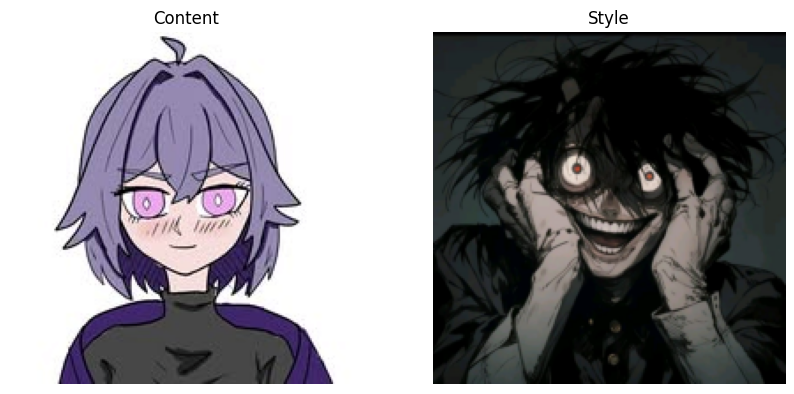

Step 0 | Total: 622.9022 | Content: 9.1775 | Style: 0.0006


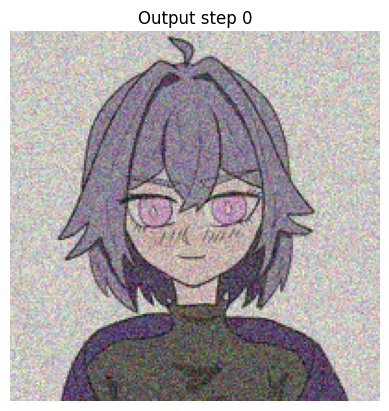

Step 100 | Total: 26.4273 | Content: 9.7015 | Style: 0.0000


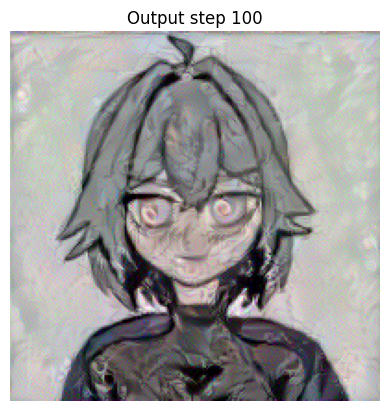

Step 200 | Total: 20.0833 | Content: 9.1539 | Style: 0.0000


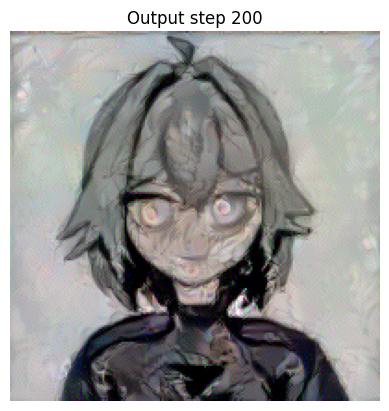

Step 300 | Total: 17.5357 | Content: 8.8496 | Style: 0.0000


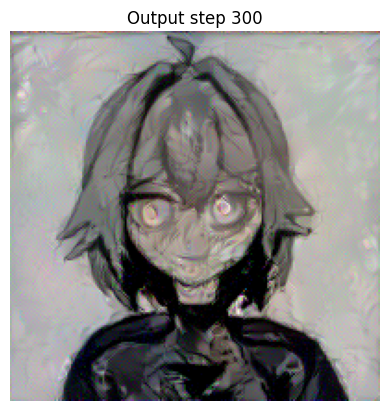

Step 400 | Total: 16.3159 | Content: 8.6629 | Style: 0.0000


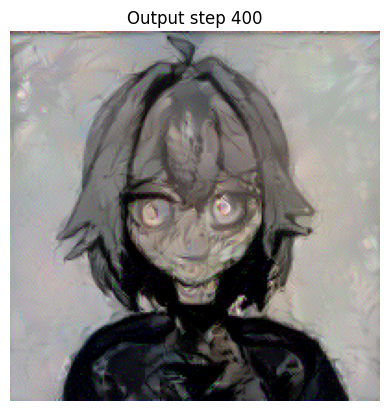

Step 500 | Total: 15.6263 | Content: 8.5432 | Style: 0.0000


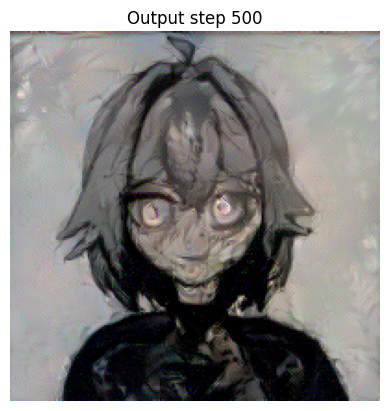

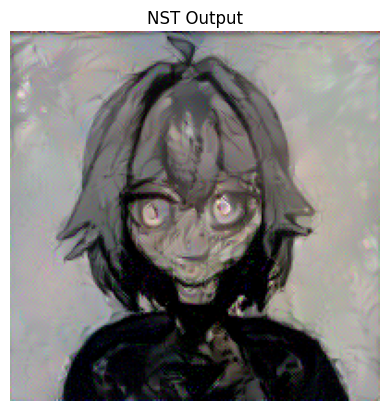

In [7]:
# =========================
# Neural Style Transfer - VGG19 (Gatys et al. 2015)
# =========================

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# =========================
# Device
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# =========================
# Load ảnh từ URL
# =========================
def load_image_from_url(url, max_size=512, shape=None):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    size = max(image.size) if max(image.size) < max_size else max_size
    if shape is not None:
        size = shape
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x[:3, :, :]),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device)

# Convert tensor → PIL để hiển thị
def im_convert(tensor):
    image = tensor.clone().detach().cpu().squeeze(0)
    image = image * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    image = image + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    image = torch.clamp(image, 0, 1)
    return transforms.ToPILImage()(image)

# =========================
# Gram Matrix
# =========================
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram / (c * h * w)

# =========================
# Feature Extractor từ VGG19
# =========================
class VGGFeatures(nn.Module):
    def __init__(self, content_layers, style_layers):
        super(VGGFeatures, self).__init__()
        self.vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features.eval()
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.content_layers = content_layers
        self.style_layers = style_layers

    def forward(self, x):
        content_features = {}
        style_features = {}
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.content_layers:
                content_features[name] = x
            if name in self.style_layers:
                style_features[name] = x
        return content_features, style_features

# =========================
# Load ảnh content & style
# =========================
content_url = "https://scontent.fsgn20-1.fna.fbcdn.net/v/t39.30808-1/530366874_1074120938159114_4888675783506621316_n.jpg?stp=c163.370.1072.1072a_dst-jpg_s200x200_tt6&_nc_cat=104&ccb=1-7&_nc_sid=e99d92&_nc_ohc=T4uVgabe1C8Q7kNvwFp3VYG&_nc_oc=AdkrNo-UpCVI6zHNqbSJGy-sfoWK3UPMaoXCcDDAFCRU4WPIC2suW6C_EphkNO48XaZwiEYyJBE3TWT_tYD7p-_x&_nc_zt=24&_nc_ht=scontent.fsgn20-1.fna&_nc_gid=gvllyfzj1so8dWvwMjK5tw&oh=00_AfZm1bDN8MeX3509Gh1olnJc7XfdhiBw4d1TrTg2AYJtBQ&oe=68C89B93"
style_url   = "https://i.pinimg.com/1200x/7d/ca/7f/7dca7f97a3cc68d79bcca48ee287d0e6.jpg"

content = load_image_from_url(content_url, max_size=256)
style   = load_image_from_url(style_url, shape=content.shape[-2])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(im_convert(content)); plt.title("Content"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(im_convert(style)); plt.title("Style"); plt.axis("off")
plt.show()

# =========================
# Init ảnh đầu vào (noise + content)
# =========================
target = (content * 0.6 + torch.randn_like(content) * 0.4).requires_grad_(True).to(device)

# =========================
# Layer chọn từ VGG19
# =========================
content_layers = ["21"]   # conv4_2
style_layers   = ["0", "5", "10", "19", "28"]  # conv1_1, conv2_1, conv3_1, conv4_1, conv5_1

# =========================
# Extractor + Feature target
# =========================
extractor = VGGFeatures(content_layers, style_layers).to(device)
content_features, _ = extractor(content)
_, style_features = extractor(style)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# =========================
# Loss Weights
# =========================
alpha = 1      # Content weight
beta  = 1e6    # Style weight

# =========================
# Optimizer
# =========================
optimizer = optim.LBFGS([target])

# =========================
# Train Loop
# =========================
steps = 500
run = [0]

while run[0] <= steps:
    def closure():
        optimizer.zero_grad()
        target_content, target_style = extractor(target)

        # Content loss
        c_loss = 0
        for layer in content_layers:
            c_loss += torch.mean((target_content[layer] - content_features[layer])**2)

        # Style loss
        s_loss = 0
        for layer in style_layers:
            target_f = target_style[layer]
            target_g = gram_matrix(target_f)
            s_loss += torch.mean((target_g - style_grams[layer])**2)

        # Total loss
        loss = alpha * c_loss + beta * s_loss
        loss.backward()

        if run[0] % 100 == 0:
            print(f"Step {run[0]} | Total: {loss.item():.4f} | Content: {c_loss.item():.4f} | Style: {s_loss.item():.4f}")
            img = im_convert(target)
            plt.imshow(img); plt.axis("off")
            plt.title(f"Output step {run[0]}")
            plt.show()

        run[0] += 1
        return loss

    optimizer.step(closure)

# =========================
# Hiển thị ảnh kết quả cuối
# =========================
final_img = im_convert(target)
plt.imshow(final_img)
plt.axis("off")
plt.title("NST Output")
plt.show()
